# **Project 1**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import linalg
from scipy.linalg import solve_triangular

from numba import jit

**Introduction**

In this project we will explore minimal norm solutions as well as Tikhonov regularisation. We will go through how truncated QR factorization can be used to efficiently compute the minimal norm solution of a underdetermined system. Additionaly we will study how singular value decomposition can be used in Tikhonov regularisation. The project will ultimately culminate into single channel source separation using techniques developed through the work on this project.

### **Minimal norm**

**1a) Underdetermined systems of linear equations**

In the following paragraph we will look at some examples of inconsistant and dependent systems of linear equations. 

We will let $m = 2$ and $n = 3$ and consider the system $A\bf{x} = \bf{y}$, hence $A \in \mathcal{M}_{2 \times 3}(\mathbb{R})$, $x \in \mathbb{R}^3$ and $y \in \mathbb{R}^2$.

*Example of inconsistant system*

$A\textbf{x} = \textbf{y}$ is inconsistant $\Longleftrightarrow$ $\text{rref}(A|y)$ has at least one row of the form $[0,0, \ldots, 0 \mid 1]$. 
To give an example of such a system, we can define $A$ and $\bf{y}$ such that the rows of $A$ are linearly dependent row vectors, i.e. the first row is a multiple of the second or vice versa. Furthermore, we must define the entries of $\textbf{y}$ such that they do not have the same corrolation as the corresponding rows of $A$. An example would be:

$A = \begin{pmatrix}
  2 & 4 & 6 \\
  1 & 2 & 3 
  \end{pmatrix} \quad \text{and} \quad
 \bf{y} = \begin{pmatrix}
  1 \\
  2 
  \end{pmatrix}$

Moreover we have: 
$(A|\bf{y}) = 
\left(\begin{array}{ccc|c}  
 2 & 4 & 6 & 2\\  
 1 & 2 & 3 & 1\\ 
\end{array}\right) \quad
\sim \quad
\left(\begin{array}{ccc|c}  
 1 & 2 & 3 & 0\\  
 0 & 0 & 0 & 1\\ 
\end{array}\right) 
$
Which clearly has no solution.


*Example of dependent system*

$A\textbf{x} = \textbf{y}$ is dependent $\Longleftrightarrow$ $\text{rref}(A|y)$ has at least one row of all zeros. Defining $A$ and $\bf{y}$ such that the first row of $(A|\bf{y})$ is a multiple of the second would yield such a dependent system. An example would be:

$A = \begin{pmatrix}
  2 & 4 & 6 \\
  1 & 2 & 3 
  \end{pmatrix} \quad \text{and} \quad
 \bf{y} = \begin{pmatrix}
  2 \\
  1 
  \end{pmatrix}$

Furthermore we have: 
$(A|\bf{y}) = 
\left(\begin{array}{ccc|c}  
 2 & 4 & 6 & 2\\  
 1 & 2 & 3 & 1\\ 
\end{array}\right) \quad
\sim \quad
\left(\begin{array}{ccc|c}  
 1 & 2 & 3 & 1\\  
 0 & 0 & 0 & 0\\ 
\end{array}\right) 
$

Which we see has infinitly manyt solutions.


**1b) Properties of $A^TA$ and $AA^T$**

In the following part we would like to prove some important characteristics of $A^TA$ and $AA^T$, where $A \in  \mathcal{M}_{m \times n}(\mathbb{R})$ and $m < n$.

**WTS:** Both $A^TA$ and $AA^T$ are symmetric

For a matrix to be symmetric it has to equal its transpose, i.e. $A = A^T$. For two arbitrary matricies $A$ and $B$ we have that $(AB)^T = B^TA^T$. This we will use without proof. From this identity the symmetric property of the matricies in question is easily derived.

\begin{aligned}
(A^TA)^T &= A^T (A^T)^T = A^T A \implies A^TA \text{ is symmetric} \\
(AA^T)^T &= (A^T)^TA^T = A A^T \implies AA^T \text{ is symmetric} \\
\end{aligned}

$\square$

**WTS:** Both $A^TA$ and $AA^T$ are positive semi-definite

$M \in  \mathcal{M}_{n\times n}(\mathbb{R})$ is a positive semi-definite matrix $\quad \Longleftrightarrow \quad \textbf{x}^T M \textbf{x} \geq  0 \space \forall \space \bf{x} \in \mathbb{R}^n$

The proof of the positive semi-definite attribute is straight forward. In the proof we are using the symmetric property proven above:

\begin{aligned}
\textbf{x}^T A^T A\textbf{x} &= (A\textbf{x})^T A\textbf{x}  \\
                             &= \textbf{y}^T \textbf{y}, \quad \quad \quad \quad \space\text{where} \space \textbf{y} = A\textbf{x} \\
                             &= \| \textbf{y} \|^2 \geq 0 \implies A^T A \space \text{is positive semi-definite}
\end{aligned}

An analogous argument can be used to show $AA^T$ is positive semi-definite:

\begin{aligned}
\textbf{x}^T A A^T \textbf{x} &= \textbf{x}^T (A A^T)^T \textbf{x} \\
                              &= \textbf{x}^T (A^T)^T A^T \textbf{x} \\
                              &= (A^T\textbf{x})^T A^T\textbf{x}  \\
                              &= \textbf{z}^T \textbf{z}, \quad \quad \quad \quad \space\text{where} \space \textbf{z} = A^T \textbf{x} \\
                              &= \| \textbf{z} \|^2 \geq 0 \implies A A^T \space \text{is positive semi-definite}
\end{aligned}

$\square$

We will now investigate the invertibility of $A^TA$ and $AA^T$, when we assume our matrix $A$ is of full rank, i.e. $\text{rank}(A) = m$. First we look at som equivalences related to invertibility of matricies. We know that any matrix represents a linear mapping. Furthermore the matrix is invertible if and only if the corresponding mapping is invertible, i.e. an isomorphism. This fact will not be proven. The following statements is therefore equivalent regarding a matrix $\Xi \in \mathcal{M}_{n \times n}(\mathbb{R})$:

\begin{aligned}
&1) \quad \Xi \space \text{is invertible} \\
&2) \quad \text{The linear mapping} \quad T(x) = \Xi x \quad \text{is an isomorphism} \\
&3) \quad \text{The linear mapping} \quad T(x) = \Xi x \quad \text{is injective} \\
&4) \quad \text{ker}(\Xi) = 0
\end{aligned}

$\Xi$ defines a linear mapping $T$ as follows:
\begin{aligned}
T: \mathbb{R}^n &\longrightarrow \mathbb{R}^n \\
x &\longrightarrow \Xi x
\end{aligned}

By definition $2) \implies 3)$. To show the converse, we use the rank-nullity theorem:

\begin{aligned}
\text{dim}(\text{im}(T)) + \text{dim}(\text{ker}(T)) &= \text{dim}(\mathbb{R}^n) , \quad \quad \quad \text{T being injective} \implies \text{ker}(T) = 0 \\
\implies \text{dim}(\text{im}(T)) + 0 &= \text{dim}(\mathbb{R}^n) \\
\implies  \text{dim}(\text{im}(T)) &= n
\end{aligned}

Since $\text{im}(T) \subseteq \mathbb{R}^n$ and they have the same dimension they are equal. Hence $3) \implies 2)$. The equivalence between $3)$ and $4)$ clearly holds. From this discussion we have that $\Xi$ being invertible is equivalent to $\text{ker}(\Xi)$ being trivial.

Now lets look at the matrix $A^TA$. 

Let $\textbf{x} \in \text{ker}(A)$

\begin{aligned}
A \textbf{x} &= 0 \\
A^TA \textbf{x} &= 0  
\implies \textbf{x} \in \text{ker}(A^TA) \implies \text{ker}(A) \subseteq \text{ker}(A^TA)
\end{aligned}
Again let $\textbf{x} \in \text{ker}(A^TA)$

\begin{aligned}
A^TA \bf{x} &= 0 \\
\textbf{x}^TA^TA \textbf{x} &= 0  \\
(Ax)^TAx &= 0 \\
\|Ax\|^2 &= 0 \implies Ax = 0 \implies \textbf{x} \in \text{ker}(A) \implies \text{ker}(A^TA) \subseteq \text{ker}(A) \\
\end{aligned}

Hence $\text{ker}(A) = \text{ker}(A^TA)$. Furthermore, from the rank-nullity theorem we can conclude:

\begin{aligned}
\text{rank}(A) = n - \text{dim}(\text{ker}(A)) = n - \text{dim}(\text{ker}(A^TA)) = \text{rank}(A^TA) = m
\end{aligned}

As stated $m \lt n \implies \text{dim}(\text{ker}(A^TA)) \gt 0 \implies A^TA$ is not invertible

Regarding $AA^T$ we can use a similar approch. From the argument above vi have that $\text{ker}(AA^T) = \text{ker}(A^T)$, and thus $\text{rank}(AA^T) = \text{rank}(A^T)$. Furthermore, we use the rank-nullity theorem to obtain:

\begin{aligned}
\text{dim}(\text{ker}(A^T)) = m - \text{rank}(A^T) = m -  \text{rank}(AA^T) = \text{dim}(\text{ker}(AA^T))
\end{aligned}

Knowing that row rank equals column rank we have that $\text{rank}(A) = \text{rank}(A^T)$. Moreover, we conclude:

\begin{aligned}
\text{dim}(\text{ker}(AA^T)) = m - \text{rank}(A^T) = m - \text{rank}(A) = m - m = 0
\end{aligned}

Hence $AA^T$ is invertible.

**1c) Minimal norm solutions**

Looking at a underdetermind system, we need supplementary assumtion on $\bf{x}$ to reach a worthwhile solution. We will now examine the minimal norm solution to this optimization problem. The minimal norm solution is defined as below:

\begin{aligned}
\textbf{x}_{\text{min}} = \underset{\textbf{x} \in \mathbb{R}^n}{\text{argmin}} \space \textbf{x}^T \textbf{x}, \quad \quad \text{such that} \space A\textbf{x} = \textbf{y}
\end{aligned}

We note that for matricies $A \in \mathcal{M}_{m \times n}(\mathbb{R})$ of full rank the solution to this problem is unique. This fact is presented in the project material, hence will not be proven. 

We are looking for saddle points of the Lagrange function, $\mathcal{L}(\textbf{x}, \boldsymbol{\lambda}) = \textbf{x}^T\textbf{x} + \boldsymbol{\lambda}^T(A\textbf{x} - \textbf{y})$, to solve the problem. Doing so, we obtain solutions where $\mathcal{L}$ is minimized with respect to $\textbf{x}$ and simultaneously maximized with respect to $\boldsymbol{\lambda}$. Moreover, a solution to the optimization problem satesfies:

\begin{aligned}
\nabla_{\textbf{x}} \mathcal{L}(\textbf{x}, \boldsymbol{\lambda}) &= 0 \\
\nabla_{\boldsymbol{\lambda}} \mathcal{L}(\textbf{x}, \boldsymbol{\lambda}) &= 0 \\
\end{aligned}

**Claim:**
The solution to this optimization problem is $\textbf{x}_{\text{min}} = A^T(AA^T)^{-1} \textbf{y}$ 

We proceed to prove this in a direct manner. First we compute the gradients with the Gateaux derivative, this procedure is explain in detail in task 2a).

\begin{aligned}
\mathcal{L}(\textbf{x}, \boldsymbol{\lambda}) 
&= \textbf{x}^T\textbf{x} + \boldsymbol{\lambda}^T(A\textbf{x} - \textbf{y}) \\
&= \textbf{x}^T\textbf{x} + \boldsymbol{\lambda}^TA\textbf{x} - \boldsymbol{\lambda}^T\textbf{y} \\
\implies \nabla_\textbf{x} \mathcal{L}(\textbf{x}, \boldsymbol{\lambda}) &= 2\textbf{x} + A^T\boldsymbol{\lambda}  \\
\implies \nabla_{\boldsymbol{\lambda}} \mathcal{L}(\textbf{x}, \boldsymbol{\lambda}) &= A \textbf{x} - \textbf{y} 
\end{aligned}

Solving for $\textbf{x}$ in first equation and substituting into the second. Moreover, we utelize the fact that $AA^T$ is invertible as previously proved.

\begin{aligned}
\nabla_\textbf{x} \mathcal{L}(\textbf{x}, \boldsymbol{\lambda}) &= 2\textbf{x} + A^T\boldsymbol{\lambda} = 0 \implies \textbf{x} = -\frac{1}{2} A^T \boldsymbol{\lambda} \\
\nabla_{\boldsymbol{\lambda}} \mathcal{L}(\textbf{x}, \boldsymbol{\lambda}) &= A \textbf{x} - \textbf{y} = 0 \implies -\frac{1}{2} AA^T \boldsymbol{\lambda} - \textbf{y} = 0
\implies \boldsymbol{\lambda} = - 2(AA^T)^{-1} \textbf{y} \\
\end{aligned}

Using this expression to solve for $\textbf{x}$

\begin{aligned}
\textbf{x} = A^T (AA^T)^{-1} \textbf{y}  
\end{aligned}

This proves the claim.

$\square$

**1d) Truncated QR decomposition > QR decomposition**

Going forward we would like to use QR decomposition to solve the optimization problem, moreover we would like to show that $\textbf{x}_{\text{min}} = QR^{-T} \textbf{y}$. 
Generally speaking; let $B \in \mathcal{M}_{m \times n}(\mathbb{R})$ where $m \gt n$. The decomposition $B = QR$ is a a QR decomposition of $B$ if $Q$ is an $m \times m$ orthogonal matrix and $R$ is $m \times n$ upper triangular one. Since $R$ is an $m \times n$ upper triangular matrix, the bottom $(m-n)$ rows will consist entirely of zeros. Storing all of these zeros is inconvinient, especially for large dimensions. One can therefore rewrite the QR decomposition to the more viable truncated QR decomposition. 

$$
B = QR = 
\begin{pmatrix}
    Q_1 & Q_2 
\end{pmatrix}
\begin{pmatrix}
    R_1 \\
    R_2 
\end{pmatrix}
=
\begin{pmatrix}
    Q_1 & Q_2 
\end{pmatrix}
\begin{pmatrix}
    R_1 \\
    0
\end{pmatrix}
=
Q_1R_1 = \tilde{Q}\tilde{R}
$$

Note that $\tilde{Q}$ has the same dimensions as $B$, i.e. $m \times n$, and $\tilde{R}$ is an $n \times n$ quadratic matrix. Furthermore, we will now refere to the truncated QR decomposition as QR decomposition.

For our implementation of the QR decomposition we are using the modified Gram-Schmidt method(MGS). The implementation is below.

In [2]:
@jit(nopython=True, fastmath = True)
def QR_MGS(A):
    '''
    QR decomposition with modified Gram-Schmidt. Taking an m x n matrix, m > n, as input.
    Returning truncated Q and R 
    '''
    Q = np.copy(A)
    m, n = np.shape(A)
    assert(m >= n)  #Checking that the dimensions are correct
    
    R = np.zeros(shape = (n, n))

    for i in range(n):
        R[i, i] = np.linalg.norm( Q[:, i] )
        Q[:, i] = Q[:, i] / R[i, i]

        for j in range(i + 1, n):
            R[i, j] = Q[:, i] @ Q[:, j]
            Q[:, j] = Q[:, j] - R[i, j] * Q[:, i]

    assert((Q@R).all() == A.all())  #Checking weather the QR decomposition is correct
    
    return Q, R

To check whether or not the implementation above yields a correct QR decomposition we will compare it to the numpy version. The QR factorisation of a matrix is not unique, in the sense that there could be sign differences between the $Q$ and $R$ matricies produced by different numerical methods. Therefore, we require the diagonal entries of $Q$ to be positive, when we compare the numpy algorithm to the one implemented above. This is done using the functions implemented below.

In [3]:
def adjust_sign(Q, R):
    '''
    Adjust the signs of the columns in Q and rows in R to
    impose positive diagonal of Q
    '''

    D = np.diag( np.sign( np.diag( Q ) ) ) #Extracting the signes of the diagonal of Q
    
    Q[:, :] = Q @ D
    R[:, :] = D @ R

    return Q, R

In [4]:
A = np.array( [ [1, 3, 3], [2, 4, 6] ], dtype= float)

q, r = np.linalg.qr(A.T)
Q, R = QR_MGS(A.T)

#Checking if our implementation returns the same as numpy.linalg.qr
assert(Q.all() == q.all()) 
assert(R.all() == r.all()) 


The code block above passeess the assertions. Since we assume that numpy.linalg.qr() produces a valid QR factorization of A, we conclude that our implementation works fine.

In our scenario we want to solve $\textbf{x}_{\text{min}} = A^T (AA^T)^{-1} \textbf{y}$ using QR decomposition. Since we are looking at a real matrix $A$ of dimension $m \times n$ where $m \lt n$ we can not use our QR decomposition algorithm directly on $A$. For our algorithm to work we need a matrix with fewer columns than rows, as well as being of full column rank. It is obvious that $A^T$ fulfill these criterias. We can therefore rewrite our optimization problem as such:

\begin{aligned} 
\textbf{x}_{\text{min}} &= A^T (AA^T)^{-1} \textbf{y} \\
\textbf{x}_{\text{min}} &= QR ((QR)^TQR)^{-1} \textbf{y}, \quad \quad \text{using that } (AB)^{-1} = B^{-1}A^{-1}, \text{ we proceed } \\
\textbf{x}_{\text{min}} &= QR (QR)^{-1}((QR)^T)^{-1} \textbf{y} \\
\textbf{x}_{\text{min}} &= ((QR)^T)^{-1} \textbf{y}  \\
\textbf{x}_{\text{min}} &= Q^{-T}R^{-T} \textbf{y}, \quad \quad \quad \text{since } Q \text{ is orthogonal } Q^{-T} = Q  \\
\implies \textbf{x}_{\text{min}} &= QR^{-T} \textbf{y}
\end{aligned} 

**1e) Calculating $\textbf{x}_{\text{min}}$**

Solving this system of linear equations is quite streight forward. We start by rephrasing our problem.

\begin{aligned}
\textbf{x}_{\text{min}} &= QR^{-T} \textbf{y} \\
\textbf{x}_{\text{min}} &= Q \textbf{z}, \quad \quad \text{where } \textbf{z} = R^{-T} \textbf{y} \\
\end{aligned}

To solve this equation we can use scipy.linalg.solve_triangular() to solve the system $R^T \textbf{z} = \textbf{y}$, since $R^T$ is a lower triangular matrix. Furthermore, multiplying the solution, $\textbf{z}$, by $Q$ gives the desired solution for $\textbf{x}_{\text{min}}$. 

Implementing a solver for such a system is easy, one can be found below.

In [5]:
def minimal_norm_solver(Q, R, y):
    '''
    Solving the system x_min = QR^(-T) y for given Q, R and y using scipy.linalg.solve_triangular().
    Returning solution to system with minimal norm.
    '''    
    z = solve_triangular( R.T, y, lower = True )
    x = Q @ z
    
    return x

In [6]:
A =  np.array( [ [2, 4, 6], [1, 3, 3] ], dtype= float )
y = np.array([2, 1], dtype=float)
Q,R = QR_MGS(A.T)

x = minimal_norm_solver(Q, R, y)
x_m = A.T @ np.linalg.inv( (A @ A.T) ) @ y

#Checking that the difference between x and x_m is below a tolerance 1e-16, i.e. machine precision
assert(np.allclose(x, x_m, atol = 1e-16)) 

From the cell above we observe that our numerical solover returns the analyticially calculated value of $\textbf{x}_{\text{min}}$.

**1f) QR vs. Numpy**


Solving the system with numpy implementations would be for us to solve the analytical expression presented in task 1c), i.e. $\textbf{x}_{\text{min}} = A^T(AA^T)^{-1}\textbf{y}$ with numpy techniques. We will use the handed out code to generate large $m \times n$ matricies as well as $100$ $\textbf{x}_{\text{true}}$'s which will be used to compute the corresponding $100$ different $\textbf{y}$'s. From here we will find the minimal norm solution for each of the $100$ systems $A\textbf{x} = \textbf{y}$, i.e. trying to find the smallest $\textbf{x}$ that solves the system. First we will look at difference in run time, this will include the actual solving as well ass the precalculations of the necessary matricies and decompositions. The following three chunks of code, are handed out code for generating the matrix $A$ as well as hundred different $\textbf{x}$'s and $\textbf{y}$'s.

In [7]:
# Generate matrix A \in \mathbb{R}^{m \times n}
def generate_A(m,n):
    '''
    Generates m times n with correlated columns.
    Input:
        m: int, first dimension of A
        n: int, second dimension of A
    output:
        A: (m,n) array
    '''

    cov_eigvecs = np.random.uniform(-1.0,1.0,(n,n))
    cov = cov_eigvecs.T @ cov_eigvecs
    v = np.sqrt(np.diag(cov))
    outer_v = np.outer(v, v)
    corr = cov / outer_v
    corr[cov == 0] = 0
    chol = sp.linalg.cholesky(corr, lower=True) 
    A = np.random.normal(0, 1.0,(m,n))
    A = np.dot(A,chol.T)
    return A

In [8]:
m = 2048
n = 8096
A = generate_A(m,n)

assert(A.shape == (m, n))

In [9]:
Q, R = QR_MGS(A.T)

In [10]:
N = 100 # Number of test data we want to generate

# Generate solutions X columnwise, X[:,i] to access i-th vector
X = np.random.normal(0.0,1.0,(A.shape[1],N))

# Generate left hand sides Y columnwise Y[:,i] to access lhs
Y = np.dot(A,X)

# Doublecheck shapes
assert(X.shape == (n, N))
assert(Y.shape == (m, N))

First off we will compare the run times of the precalculating stage. That is comparing the time used for our algorithem to QR factorice the matrix $A^T$ to the time it takes to calculate $A^T$ and $(AA^T)$.

In [ ]:
%%timeit -r 5
Q, R = QR_MGS(A.T)

In [ ]:
%%timeit -r 5
AAT = A @ A.T

569 ms ± 10.1 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


From the results above we see a huge difference in run time for the precalculating step. The time spent in this stage for the numpy method is roughly $1 \%$ of the time used for the QR method. This is by no means a suprise, our QR factorisation does a lot more calculations than what is needed for multiplying $A^T$ by $A$. We will now proceed to compare the difference in run time when it comes to computing the solution $\textbf{x}_{\text{min}}$ for $100$ different $\textbf{y}$'s. Furthermore, we will store the difference $\|\textbf{x}_{\text{true}} - \textbf{x}_{\text{min}}\|$ for every $\textbf{x}_{\text{min}}$ we calculate.

In [ ]:
N_array = np.linspace(0, N, N)  # Initializing array to plot ||x_true - x_min|| and ||x_numpy - x_qr||
AAT = np.dot(A, A.T) # Precalculating AA^T
Q, R = QR_MGS(A.T) # Precalculating QR decomposition of A^T

# Initializing arrays to hold ||x_true - x_min|| for both numpy and QR solver, 
# array to hold ||x_numpy - x_qr|| and ||x_true|| - ||x_qr||
norm_array_np = np.zeros(N) 
norm_array = np.zeros(N)
norm_array_diff = np.zeros(N)

In [ ]:
%%timeit -r 1 -n 1
# Solving system with numpy implementations
for i in range(N):
    z = np.linalg.solve(AAT,Y[:,i])
    x_sol_np = np.dot(A.T,z)

    norm_array_np[i] = np.linalg.norm(x_sol_np - X[:, i])

17.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
%%timeit -r 1 -n 1
# Solving system with QR implementation
for i in range(N):
    x_sol = minimal_norm_solver(Q, R, Y[:, i])

    norm_array[i] = np.linalg.norm(x_sol - X[:, i])

1.48 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Agein we see a huge difference in run time, but this time, in favor of the QR method. We now observe that solving $100$ systems with the QR method takes about $7 \%$ of the time spent by the numpy method. The beauty of matrix factorisation is the ability to reduce the amount of calculations needed in order to solve the system. In our case, solving a system which matrix is triangular is extremely efficient, when done right. Therefore, observing that $100$ systems are solved faster with the QR factorisation is not a thunderbolt.

However, this is when we do not consider the time spent to compute the QR decomposition. Looking at the time used to compute the QR factorization, we see that using the numpy method would be favorible in our case. Nevertheless, we discern that for a given $A$ the more systems you want to solve, the faster the QR method will be compared to the numpy method.

In [ ]:
# Solving the systems at the same time to 
# observe the difference between them
for i in range(N):
    z = np.linalg.solve(AAT,Y[:,i])
    x_sol_np = np.dot(A.T,z)

    x_sol = minimal_norm_solver(Q, R, Y[:, i])

    norm_array_diff[i] = np.linalg.norm(x_sol_np - x_sol)


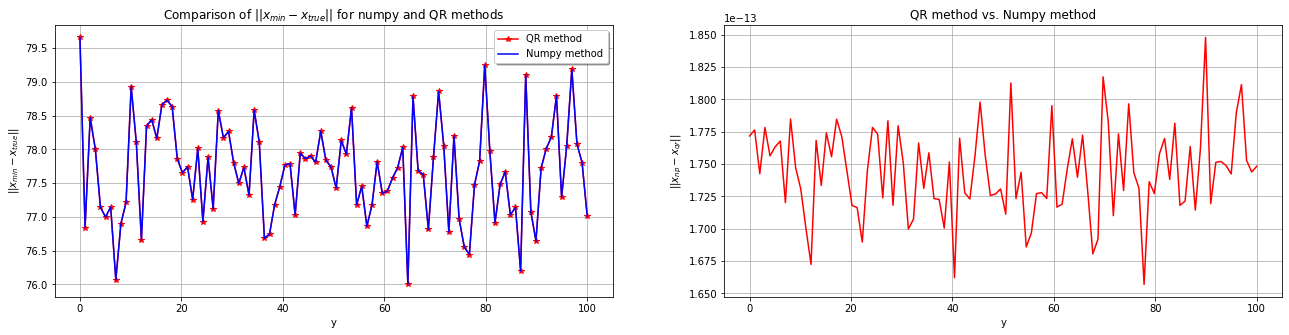

The norm of x_true is around: 90.90240647832151


In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (22, 5))

ax[0].plot(N_array, norm_array, '-*', c = 'r', label = "QR method")
ax[0].plot(N_array, norm_array_np, 'b', label = "Numpy method")
ax[0].legend(shadow = True)
ax[0].set_title(r'Comparison of $||x_{min} - x_{true}||$ for numpy and QR methods')
ax[0].set(xlabel= r'y', ylabel = r'$||x_{min} - x_{true}||$')
ax[0].grid()

ax[1].plot(N_array, norm_array_diff, 'r')
ax[1].set_title("QR method vs. Numpy method")
ax[1].set(xlabel= r'y', ylabel = r'$||x_{np} - x_{qr}||$')
ax[1].grid()
plt.show()

x_true_norm = np.linalg.norm(X, axis=0)
print(f'The norm of x_true is around: {x_true_norm}')

The plots above showcases some properties with both the systems and the methods used to solve them. We stated earlier that the minimal norm solution for a matrix of full rank is unique. From the above plots we observe that the difference between the solutions obtained from the two methods is of magnitude $10^{-13}$. These differences are in the realm of machine precision. It is therefore reasonable to conclude that both methods results in the same minimizer. 

Our goal is to obtain the $\textbf{x}$ with the smallest corresponding norm, $\|\textbf{x}\|$, that solves the system $A\textbf{x} = \textbf{y}$. We see that the norm of $\textbf{x}_{\text{true}}$ is around $90$, while $\|\textbf{x}_{\text{true}}-\textbf{x}_{\text{min}} \|$ is in the area of $77$. Our solution is thereby a great improvement to $\textbf{x}_{\text{true}}$ which is what we are looking for. 

### **Tikhonov regularisation** 

The underdetermined system $A\textbf{x} = \textbf{y}$ can not only be solved using constraints, but one can also examine the least squares solution:

$$\underset{\textbf{x} \in \mathbb{R}^n}{\text{argmin}} \space \| A\textbf{x} - \textbf{y} \|^2$$

By adding a weight $\mu > 0$, one can obtain the Tikhonov regularisation:

$$\textbf{x}_{\text{r}} = \underset{\textbf{x} \in \mathbb{R}^n}{\text{argmin}} \space \| A\textbf{x} - \textbf{y} \|^2 + \mu \|x\|^2$$

And for practicality we define $T(\textbf{x}) \triangleq \| A\textbf{x} - \textbf{y} \|^2 + \mu \|\textbf{x}\|^2$.

**2a) Solving Tikhonov regularisation**

We know a solution of the Tikhonov regularisation satisfies $\nabla_{\textbf{x}}T(\textbf{x}) = 0$. From this one can show that a solution $\textbf{x}$ will fulfill $(A^TA + \mu I)\textbf{x}_{\text{r}} = A^T\textbf{y}$. To show this I will first find the gradient using the Gateaux differential, from this showing the claim above is an easy task.

\begin{aligned}
T(\textbf{x}) &= \langle A\textbf{x} - \textbf{y}, A\textbf{x} - \textbf{y} \rangle + \mu \langle \textbf{x}, \textbf{x} \rangle \\
&=  (A\textbf{x} - \textbf{y})^T (A\textbf{x} - \textbf{y}) + \mu \textbf{x}^T \textbf{x} \\
&= \textbf{x}^TA^TA\textbf{x} -\textbf{x}^TA^T\textbf{y} - \textbf{y}^TA\textbf{x} + \textbf{y}^T\textbf{y} + \mu \textbf{x}^T \textbf{x} \\
\end{aligned}

Due to the nature of scalars we have the following:
$\textbf{x}^T A^T \textbf{y} \in \mathbb{R} \implies \textbf{x}^T A^T \textbf{y} = (\textbf{x}^T A^T \textbf{y})^T = \textbf{y}^T (\textbf{x}^T A^T)^T = \textbf{y}^T Ax$. 

Hence 
$$T(x)= \textbf{x}^TA^TA\textbf{x} - 2\textbf{y}^TA\textbf{x} + \textbf{y}^T\textbf{y} + \mu \textbf{x}^T \textbf{x}$$

Applying Gateaux derivative

\begin{aligned}
&\left.\frac{d}{d\varepsilon} \right |_{\varepsilon=0} (\textbf{x} + \varepsilon e)^T A^T A (\textbf{x} + \varepsilon e) - 2\textbf{y}^TA(\textbf{x} + \varepsilon e) + \textbf{y}^T\textbf{y} + \mu (\textbf{x} + \varepsilon e)^T (\textbf{x}+ \varepsilon e) \\

= &\left.\frac{d}{d\varepsilon} \right |_{\varepsilon=0} \textbf{x}^T A^T A \textbf{x} + \varepsilon \textbf{x}^T A^T A  e + \varepsilon e^T A^T A \textbf{x} + \varepsilon^2 e^T A^T A e + 2\textbf{y}^TA\textbf{x} + 2\textbf{y}^TA\varepsilon e + \textbf{y}^T\textbf{y} + \mu (\textbf{x}^T\textbf{x} + 2\textbf{x}^T\varepsilon e + \varepsilon^2 e^Te) \\
\end{aligned}

From this we easily obtain the following:
\begin{aligned}
\textbf{x}^T A^T A e + e^T A^T A \textbf{x} + 2\textbf{y}^TAe + 2 \textbf{x}^Te = 2 \langle A^T A \textbf{x}, e \rangle - 2 \langle A^T \textbf{y}, e \rangle + 2 \mu \langle \textbf{x}, e \rangle  
\end{aligned}
$e$ being unit vectors we finaly obtain
$$\nabla_{\textbf{x}}T(\textbf{x}) = 2 A^TA \textbf{x} - 2 A^T \textbf{y} + 2 \mu \textbf{x}$$
Setting the gradient to zero.
$$2 A^TA \textbf{x} - 2 A^T \textbf{y} + 2 \mu \textbf{x} = 0 \implies (A^TA + \mu I) \textbf{x}_{r} = A^T \textbf{y}$$

**Claim:** $A^TA + \mu I$ is symmetric positive-definite (SPD)

$M \in  \mathcal{M}_{n\times n}(\mathbb{R})$ is a SPD $\quad \Longleftrightarrow \quad \textbf{x}^T M \textbf{x} \gt 0  \space \forall \space \bf{x} \in \mathbb{R}^n \setminus \{0\}$ and $M^T = M$

Lets first consider the symmetric property:
$(A^TA + \mu I)^T = (A^TA)^T +  \mu I^T = A^TA +  \mu I \implies A^TA + \mu I$ is symmetric.

Proving $A^TA + \mu I$ being positive-definite is quite straight forward:
\begin{aligned}
\textbf{x}^T (A^TA + \mu I) \textbf{x} &= \textbf{x}^T A^TA \textbf{x} +  \mu \textbf{x}^T I \textbf{x}^T \\
&= \langle A\textbf{x}, A\textbf{x} \rangle +  \mu \langle \textbf{x}, \textbf{x} \rangle \\
&= \|A\textbf{x}\|^2 +  \mu \|\textbf{x}\|^2 \geq 0 +  \mu \|\textbf{x}\|^2 \gt 0, \quad \forall \textbf{x} \space \in \mathbb{R}^n \setminus \{0\}
\end{aligned}

The last inequality comes from positive difinitness of norms.

This concludes the argument.

$\square$


**2b) Rewriting $\textbf{x}$ interms of SVD decomposition**

**Claim:** For $A = U\Sigma V^*$ we have $\textbf{x}_r = VDU^T\textbf{y}$, for $D$ a diagonal matrix

In our case both $U$ and $V$ is unitary and real which implies $U^{*} = U^T = U^{-1} = U$, the same equality holds for $V$ as well.

Starting of: $(A^TA + \mu I)\textbf{x}_{\text{r}} = A^T\textbf{y} \implies (V\Sigma^T U^T U \Sigma V^T + \mu I)\textbf{x}_{\text{r}} = V \Sigma^T U^T \textbf{y}$

Furthermore, $\Sigma$ is a diagonal matrix. This gives:

\begin{aligned}
(V\Sigma^T \Sigma V^T + \mu I)\textbf{x}_{\text{r}} &=
(V\Sigma^T \Sigma V^T + \mu I)\textbf{x}_{\text{r}} \\
&= (V\Sigma^T \Sigma V^T + \mu V I V^T)\textbf{x}_{\text{r}} \\
&= V(\Sigma^T \Sigma + \mu I) V^T\textbf{x}_{\text{r}} \\
\end{aligned}

$\Sigma$ is diagonal, hence $\Sigma^T \Sigma$ is diagonal. Moreover, the sum $\Sigma^T \Sigma + \mu I$ is also diagonal. For practicality we define $D \triangleq \Sigma^T \Sigma + \mu I$.

\begin{aligned}
V(\Sigma^T \Sigma + \mu I) V^T\textbf{x}_{\text{r}} &= 
V D V^T\textbf{x}_{\text{r}} \\
&= V D V^T\textbf{x}_{\text{r}} = V \Sigma^T U^T \textbf{y}
\end{aligned}

This expression can be further simplified:

\begin{aligned}
D V^T\textbf{x}_{\text{r}} &=  \Sigma^T U^T \textbf{y} \\
\implies V^T\textbf{x}_{\text{r}} &=  D^{-1} \Sigma^T U^T \textbf{y}, \quad D \space  \text{is diagonal} \implies D^{-1} \space \text{is diagonal} \implies \tilde{D} \overset{\Delta}{=} D^{-1} \space \Sigma^T \space \text{is also diagonal} \\
\implies \textbf{x}_{\text{r}} &=  V \tilde{D} U^T \textbf{y}
\end{aligned}

This proves the claim.

$\square$

**2c) Solving Tikhonov regularisation with SVD approch**

We will now proceed with solving the Tikhonov regularisation with the SVD approch outlined above. This is efficient to compute knowing the singular value decomposition of $A$ and the parameter $\mu$. Using the SVD function from the numpy library, we acquire $U$ and $V$, as well as a vector containg the singular values of A, i.e. the diagonal entries of $\Sigma$. These matricies, coupled with the parameter $\mu$ as well as a vector $\textbf{y}$, can be used to solve the Tikhonov regularisation.

In [ ]:
def Tikhonov_solveSVD(U, S, Vt, mu, y):
    '''
    Solving tikhonov regularisation with SVD decomposition of A.

    Returning x_r = V D U.T y, where D[i, i] = S[i] / (S[i]^2 + \mu) 
    '''

    x_r = Vt.T * (S / (S**2 + mu)) @ U.T @ y

    return x_r

**2d) Changing $\mu$**

We will now use our SVD approch to find the least squares solution to the system $A\textbf{x} - \textbf{y}$. We will use the Tikhonov regularisation with 100 different values of $\mu$, and search for which $\mu$ that provieds the best reconstruction of $\textbf{x}_{\text{true}}$. 

In the following code chunks we  comparing our SVD procedure against numpy implementations. First off we will compare the time used to solve one instance of the problem for both methods, and afterward look at the difference in run time when solving for 100 different values of $\mu$

In [ ]:
m = 2048
n = 8096
A = generate_A(m,n)

X = np.random.normal(0.0, 1.0, A.shape[1])
Y = A @ X

mu_array = np.logspace(6, -6, num = 100)
mu_np_array = np.logspace(8, -6, 20)

assert(A.shape == (m, n))
assert(X.shape == (n, )) 
assert(Y.shape == (m, )) 

U, S, Vt = np.linalg.svd(A, full_matrices = False)
ATA = A.T @ A

x_mu_array_np = np.zeros(len(mu_np_array))
x_mu_array_SVD = np.zeros( len(mu_array) )


In [ ]:
%%timeit -r 1 -n 1
mu = 0
x = Tikhonov_solveSVD(U, S, Vt, mu, Y)

1.16 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
%%timeit -r 1 -n 1
mu = 1e-1
x = np.linalg.solve( ATA + mu * np.eye(np.shape(ATA)[0]), A.T @ Y )

6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


We see that for a given $\mu$ obtaining the least squares solution is more time efficient with the SVD procedure. This is reasonable, because numpy.linalg.solve() LU decomposes the matrix before solving the system with forwards and backwards substitution. Our SVD approch, takes the matrix decomposition as input, and therefore solves the system directly from the get go. 

In [ ]:
for i, mu in enumerate(mu_array):
    x_mu = Tikhonov_solveSVD(U, S, Vt, mu, Y)
    x_mu_array_SVD[i] = np.linalg.norm( x_mu - X )


In [ ]:
for i, mu in enumerate(mu_np_array):
    x_mu = np.linalg.solve( ATA + mu * np.eye(np.shape(ATA)[0]), A.T @ Y )

    x_mu_array_np[i] = np.linalg.norm( x_mu - X )

In [ ]:
Q, R = np.linalg.qr(A.T)

x_min = minimal_norm_solver(Q, R, Y)
x_min_norm = np.linalg.norm(x_min - X)

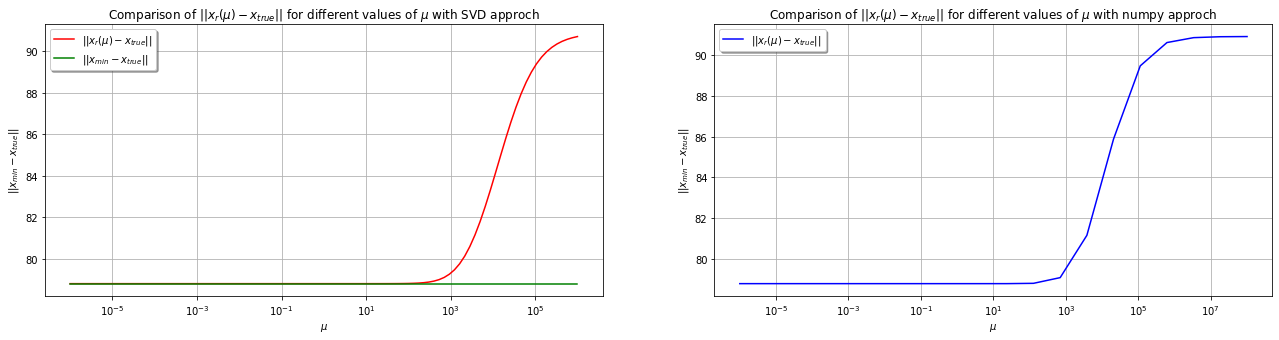

In [ ]:
fig, ax = plt.subplots(1,2 , figsize = (22, 5))

ax[0].plot(mu_array, x_mu_array_SVD, 'r', label = r'$||x_r(\mu) - x_{true}||$')
ax[0].plot(mu_array, np.full( len(mu_array), x_min_norm ), color = 'g', linestyle = '-', label = r'$||x_{min} - x_{true}||$')
ax[0].set_xscale('log')
ax[0].legend(shadow = True)
ax[0].set_title(r'Comparison of $||x_r(\mu) - x_{true}||$ for different values of $\mu$ with SVD approch')
ax[0].set(xlabel= r'$\mu$', ylabel = r'$||x_{min} - x_{true}||$')
ax[0].grid()

ax[1].plot(mu_np_array, x_mu_array_np, 'b', label = r'$||x_r(\mu) - x_{true}||$')
ax[1].set_xscale('log')
ax[1].legend(shadow = True)
ax[1].set_title(r'Comparison of $||x_r(\mu) - x_{true}||$ for different values of $\mu$ with numpy approch')
ax[1].set(xlabel= r'$\mu$', ylabel = r'$||x_{min} - x_{true}||$')
ax[1].grid()

plt.show()

Looking at the two graphs we observe a titration curve like plot. Furthermore, we see that the value $\| \textbf{x}_r(\mu) - \textbf{x}_{\text{true}}\|$ is for all practical purposes constant for $\mu \lessapprox 10$. This is not unexpected. The main motivation behind Tikhonov regularisation is to obtain a balance between solving the system $A\textbf{x} = \textbf{y}$ and obtaining an $\textbf{x}$ of smallest possible norm. In the task presented we have no interest in obtaining an $\textbf{x}$ of the smallest possible norm. However, we are looking for the best reconstruction of $\textbf{x}_{\text{true}}$. 

We recall how $\textbf{x}_{\text{true}}$ and $\textbf{y}$ are constructed. Firstly we constructed $\textbf{x}_{\text{true}}$ and from here created $\textbf{y} \triangleq A\textbf{x}_{\text{true}}$. Hence $\underset{\textbf{x} \in \mathbb{R}^n}{\text{argmin}} \space \| A\textbf{x} - \textbf{y} \|^2 = \tilde{\textbf{x}}$, such that $A\tilde{\textbf{x}} = \textbf{y}$. One such solution for $\tilde{\textbf{x}}$ could obviously be $\textbf{x}_{\text{true}}$. In Tikhonov regularisation the weighted term $\mu\|\textbf{x}\|^2$ can only push the solution $\textbf{x}_r(\mu)$ away from any solution $\tilde{\textbf{x}}$, as a concequence of the positive definiteness of the norm. By this logic it is clear that the best reconstruction of $\textbf{x}_{\text{true}}$ comes from locating $\underset{\textbf{x} \in \mathbb{R}^n}{\text{argmin}} \space \| A\textbf{x} - \textbf{y} \|^2$ rather than finding $\underset{\textbf{x} \in \mathbb{R}^n}{\text{argmin}} \space \| A\textbf{x} - \textbf{y} \|^2 + \mu \|x\|^2$. Therefore, it is no bobshell that $\| \textbf{x}_r(\mu) - \textbf{x}_{\text{true}}\|$ converges when $\mu$ goes to zero. However, it looks like $\textbf{x}_r(\mu)$ converges to the minimal norm solution and does not come any closer to $\textbf{x}_{\text{true}}$. The limit is in fact the minimal norm solution and this is proven below using SVD.

We begin looking at the solution to the regularization probelem deduced in task 2b):

\begin{aligned}
\textbf{x}_{\text{r}} &=  V \tilde{D} U^T \textbf{y} = V (\Sigma^T \Sigma + \mu I)^{-1} \Sigma^T U^T \textbf{y}
\end{aligned}

By taking the limit when $\mu$ goes to $0$ we obtain:

\begin{aligned}
\lim_{\mu \to 0}  V (\Sigma^T \Sigma + \mu I)^{-1} \Sigma^T U^T \textbf{y} =
V (\Sigma^T \Sigma)^{-1} \Sigma^T U^T \textbf{y} = V \Sigma^{-1} U^T \textbf{y}
\end{aligned}

From task 1c) we can rephrase the minimal norm solution:

\begin{aligned}
\textbf{x}_{\text{min}} &= A^T(AA^T)^{-1} \textbf{y} = V \Sigma^T U^T ( U \Sigma V^T V \Sigma^T U^T)^{-1} \textbf{y} \\
&= V \Sigma^T U^T U \Sigma^{-T} \Sigma^{-1} U^T \textbf{y} = V \Sigma^{-1} U^T \textbf{y}
\end{aligned}

This showes that the we obtain the minimal norm solution with Tikhonov regularisation.

### **Single Channel Source Separation**

We will now examine a more practical problem. Assuming we know $\textbf{y} \in \mathbb{R}^n$ contains two separate channels, $\textbf{u} \in \mathbb{R}^n$ and $\textbf{v} \in \mathbb{R}^n$. Rephrasing this as a linear system of equations we obtain:

$$
\textbf{u} + \textbf{v} = A \textbf{x} =
\begin{pmatrix}
I & I 
\end{pmatrix}
\begin{pmatrix}
\textbf{u} \\
\textbf{v}
\end{pmatrix}
= \textbf{y} 
$$

Note that $\textbf{x} \in \mathbb{R}^{2n}$ and $A \in \mathcal{M}_{n \times 2n}(\mathbb{R})$.

In this task we will solve the single channel source separation problem for pictures of digit 0 and 1. These are from the MNIST dataset. We will look at pictures, i.e. $\textbf{y}$, which is a sum of 0 digits and 1 digits. $\textbf{u}$ will represent the digit 0 and $\textbf{v}$ will represent the digit 1.

**3a) Projection matrix**

Let $B = I - WW^T$, where $W = \begin{pmatrix} W_1 & W_2 & \ldots & W_d \end{pmatrix}$ is a matrix with pairwise orthonormal columns, i.e. $W_i^T W_j = 0 \quad \forall i≠j \space\wedge \space W_i^T W_j = 1 \quad \forall i = j.$


**Claim:** B is a symmetric positive semi-definite projection matrix.

For $B$ to be a projection matrix it must satisfy $B^2 = B$. This is straight forward to prove.

\begin{aligned}
B^2 = (I - WW^T)^2 = I^2 - WW^T - WW^T + (WW^T)^2 = I - 2WW^T + WW^T = I - WW^T = B \implies B \text{ is a projection matrix}
\end{aligned}

The third equality comes from the following, which comes directly from the orthonormality of the columns of $W$:

\begin{aligned}
W^TW = 
\begin{pmatrix}
W_1^TW_1 & W_1^TW_2 & \ldots & W_1^TW_n \\
W_2^TW_1 & W_2^TW_2 &  & \vdots \\
\vdots &  & \ddots & \vdots \\
W_n^TW_1 & \ldots & \ldots & W_n^TW_n \end{pmatrix}
= 
\begin{pmatrix}
1 & 0 & \ldots & 0 \\
0 & 1 &  & \vdots \\
\vdots &  & \ddots & \vdots \\
0 & \ldots & \ldots & 1 \end{pmatrix}
=I
\end{aligned}

$B$ being symmetric is also easily proved in a direct manner:

\begin{aligned}
B^T = (I - WW^T)^T = I^T - (WW^T)^T = I - (W^T)^TW^T = I - WW^T = B \implies B \text{ is symmetric}
\end{aligned}

To prove $B$ to be positive semi-definite we recall that a matrix is positive semi-definite if and only if its eigenvalues are real and non-negative. Suppose $\lambda$ is an eigenvalue of $B$.

\begin{aligned}
B^2 x = B(Bx) = B(\lambda x) = \lambda(Bx) = \lambda^2 x \implies \lambda^2 = \lambda \in \mathbb{R} \implies \lambda = 0 \space \lor \space \lambda = 1
\end{aligned}

Therefore every eigenvalue of $B$ is either $0$ or $1$. Hence $B$ is positive semi definite.
This concludes the proof.

$\square$


**3b) Minimal norm solution**

*1)*

As provided the minimal norm formulation is as follows:
$$\underset{\textbf{x}}{\text{argmin}} \frac{1}{2} \textbf{x}^T B \textbf{x}, \quad \quad \text{such that } A\textbf{x} = \textbf{y}$$

Where 
$$B = \begin{pmatrix} B_0 & 0 \\ 0 & B_1 \end{pmatrix}, \quad \quad A = \begin{pmatrix} I & I \end{pmatrix}$$

The corresponding Lagrangian function is therefore:
$$\mathcal{L}(\textbf{x}, \boldsymbol{\lambda}) = \frac{1}{2} \textbf{x}^T B \textbf{x} + \boldsymbol{\lambda}^T(A \textbf{x} - \textbf{y})$$

As discussed in task 1, the unique solution to this optimization problem satisfies:
\begin{aligned}
\nabla_{\textbf{x}} \mathcal{L}(\textbf{x}, \boldsymbol{\lambda}) &= 0 \\
\nabla_{\boldsymbol{\lambda}} \mathcal{L}(\textbf{x}, \boldsymbol{\lambda}) &= 0 \\
\end{aligned}

Using the results from task 1, we obtain:
\begin{aligned}
\nabla_{\textbf{x}} \mathcal{L}(\textbf{x}, \boldsymbol{\lambda}) &= B \textbf{x} + A^T \boldsymbol{\lambda} = 0  \\
\nabla_{\boldsymbol{\lambda}} \mathcal{L}(\textbf{x}, \boldsymbol{\lambda}) &= A \textbf{x} - \textbf{y} = 0 \implies A \textbf{x} = \textbf{y} 
\end{aligned}

This can be expressed in terms of a vector equation:

\begin{aligned}
\begin{pmatrix}
B \textbf{x} + A^T \boldsymbol{\lambda} \\
A \textbf{x}\end{pmatrix}
=
\begin{pmatrix}
B & A^T  \\
A & 0\end{pmatrix}
\begin{pmatrix}
\textbf{x} \\
\boldsymbol{\lambda} \end{pmatrix}
= 
\begin{pmatrix}
0 \\
\textbf{y} \end{pmatrix}
\end{aligned}

As described before $B$ is symmetric. Which implies $B = \frac{1}{2} B + \frac{1}{2} B = \frac{1}{2} B^T + \frac{1}{2} B$. Moreover, we obtain the expressen provided:

\begin{aligned}
\begin{pmatrix}
\frac{1}{2} B^T + \frac{1}{2} B & A^T  \\
A & 0\end{pmatrix}
\begin{pmatrix}
\textbf{x} \\
\boldsymbol{\lambda} \end{pmatrix}
= 
\begin{pmatrix}
0 \\
\textbf{y} \end{pmatrix}
\end{aligned}

Furthermore, we can express $A$, $B$ and $\textbf{x}$ interms of how they are defined. This yields:
\begin{aligned}
\begin{pmatrix}
B_0 & 0 & I \\
0 & B_1 & I  \\
I & I & 0\end{pmatrix}

\begin{pmatrix}
\textbf{u} \\ 
\textbf{v}  \\
\boldsymbol{\lambda} \end{pmatrix}
= 
\begin{pmatrix}
0 \\
0 \\
\textbf{y} \end{pmatrix}
\end{aligned}

Plugging in for $B_0$ and $B_1$ we conclude:

\begin{aligned}
\begin{pmatrix}
I - W_0W_0^T & 0 & I \\
0 & I-W_1W_1^T & I  \\
I & I & 0\end{pmatrix}

\begin{pmatrix}
\textbf{u} \\ 
\textbf{v}  \\
\boldsymbol{\lambda} \end{pmatrix}
= 
\begin{pmatrix}
0 \\
0 \\
\textbf{y} \end{pmatrix}
\end{aligned}

*2)*

This particular set of linear equations can be rewritten to a simplier form, in which we do not lose any information. More precisely, the equation can be expressed on the form $C \textbf{u} = \textbf{d}$, for some matrix $C$, smaller than the one presented above, and a vector $\textbf{d}$. This new system does not lose any information, i.e. we still obtain the relation $\textbf{u} + \textbf{v} = \textbf{y}$. This new system is obtained like this:

\begin{aligned}
B_0 \textbf{u} + \boldsymbol{\lambda}I &= 0 \\
B_1 \textbf{v} + \boldsymbol{\lambda}I &= 0 \\
\Downarrow \\
B_0 \textbf{u} - B_1 \textbf{v}  &= 0, \quad \quad \textbf{v} = \textbf{y} - \textbf{u} \\
B_0 \textbf{u} - B_1 (\textbf{y} - \textbf{u}) &= 0 \\
\underbrace{(B_0 + B_1)}_{C} \textbf{u} &= \underbrace{B_1 \textbf{y}}_{\textbf{d}}
\end{aligned}

We have now rewritten our set of equations to $C \textbf{u} = \textbf{d}$. It remains to show that $\textbf{v} = \textbf{y} - \textbf{u}$ from this simplified expression. Using $B_0 \textbf{u} = B_1 \textbf{v}$ we simplify:

\begin{aligned}
B_0 \textbf{u} + B_1 \textbf{u} = B_1 \textbf{v} + B_1 \textbf{u} = B_1 \textbf{y} \implies \textbf{v} + \textbf{u} = \textbf{y} \implies \textbf{v} = \textbf{y} - \textbf{u}
\end{aligned}

This showes that $C \textbf{u} = \textbf{d}$, for $C = B_0 + B_1$ and $\textbf{d} = B_1 \textbf{y}$, is a more compact system to solve.

*3)*

We will now proceed to solve this by the minimal norm approch. To choose which approch to take there is a lot of factors to take into consideration. First of, the matrix $C$ has alot of 0 entries, i.e. the system is sparse. Iterative methods was developed to utilize this property of the system to make faster algorithms. However, the system we are examining is by no means a large system so the reduction in run time will probebly not be significant. Furthermore, an iterative method would use a stoping criteria, and thus lose some information along the way. If we look at matrix factorization approches, we have two viable options. We could use numpy.linalg.solve(), or we could QR decompose $C$ and further use our algorithm to solve for the minimal norm solution. Both of these would be very easy to implement. Moreover, they both use highly optimized algorithms from the numpy and scipy library, which will most likely solve our system reasonably fast. Since we are going to solve the system $100$ times for the same matrix $C$, we will proceed with the QR method in the same manner as in task 1. 

We attack the problem in the same way as in 1e). First we use QR decomposition on $C$, and uses this to solve the system $C \textbf{x} = \textbf{d}$. We will also implement a function using the numpy.linalg.solve() approch, and see that the QR method is faster when we solve 100 systems.

In the three following code blocks we are loading in all of the necessary data and constructing all of the necessary matricies and decompositions. Furthermore, we implement the two algorithms we are going to use. 

In [ ]:
W0 = np.load('Data/W0.npy') # Loading basis vectors of 0 digit
W1 = np.load('Data/W1.npy') # Loading basis vectors of 1 digit
Mixes = np.load('Data/mixed.npy') # Loading Mixed pictures

N = len(Mixes[0,:])

# Creating C matrix, and preforming QR decomposition 
B_0 = np.identity(784) - W0 @ W0.T  
B_1 = np.identity(784) - W1 @ W1.T

C = B_0 + B_1
Q_C, R_C = np.linalg.qr(C)

# Checking correct QR factorisation
assert(np.allclose(Q_C @ R_C, C))

# Checking importet dimensions and 
assert(Mixes.shape == (784, 100)) 
assert(W0.shape == (784, 16)) 
assert(W1.shape == (784, 16)) 

In [ ]:
def separate(C, y):
    '''
    Separating the two chennels u and v
    Input:
        n x n matrix C
        n x 1 matrix y
    Return:
        n x 1 matrix u
        n x 1 matrix v
    '''
    d = B_1 @ y
    u = np.linalg.solve(C, d)
    v = y - u
    return u, v

In [ ]:

def separate_QR(Q, R, y):
    '''
    Separating the two chennels u and v
    Input:
        n x n matrix Q
        n x n upper triangular matrix R
        n x 1 matrix y
    Return:
        n x 1 matrix u
        n x 1 matrix v
    '''
    d = B_1 @ y
    u = minimal_norm_solver(Q, R, d)
    v = y - u
    return u, v

The three next code blocks times our separation algorithms, to see which is faster.

In [ ]:
%%timeit -r 5 
m = Mixes[:, 98]
u, v = separate(C, m)

7.9 ms ± 166 µs per loop (mean ± std. dev. of 5 runs, 100 loops each)


In [ ]:
%%timeit -r 5 
Q, R = np.linalg.qr(C)
m = Mixes[:, 98]
u, v = separate_QR(Q, R, m)

41.3 ms ± 2.2 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [ ]:
%%timeit -r 5 
m = Mixes[:, 98]
u, v = separate_QR(Q_C, R_C, m)

1.2 ms ± 88.9 µs per loop (mean ± std. dev. of 5 runs, 1000 loops each)


We observe from the above cells that solving the system when QR factorization has already been done, is by far the fastest approch. However we see that solving the system using numpy.linalg.solve() is faster when QR has not been computed earlier.

**3d)**

We will now carry on to examining if our method is able to separate the two digits.  We will also see how fast the two methods are compared to each other.

In [ ]:
%%timeit -r 1
Q_C, R_C = np.linalg.qr(C)
for i in range(N):
    m = Mixes[:, i]
    u, v = separate_QR(Q_C, R_C, m)


163 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [ ]:
%%timeit -r 1
for i in range(N):
    m = Mixes[:, i]
    u, v = separate(C, m)

937 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Again we observe that factorizing the matrix beforehand is way faster than calculating it in every single instace of solving the system.

In [ ]:
m1 = Mixes[:, 42]
u1, v1 = separate_QR(Q_C, R_C, m1)

m2 = Mixes[:, 69]
u2, v2 = separate_QR(Q_C, R_C, m2)

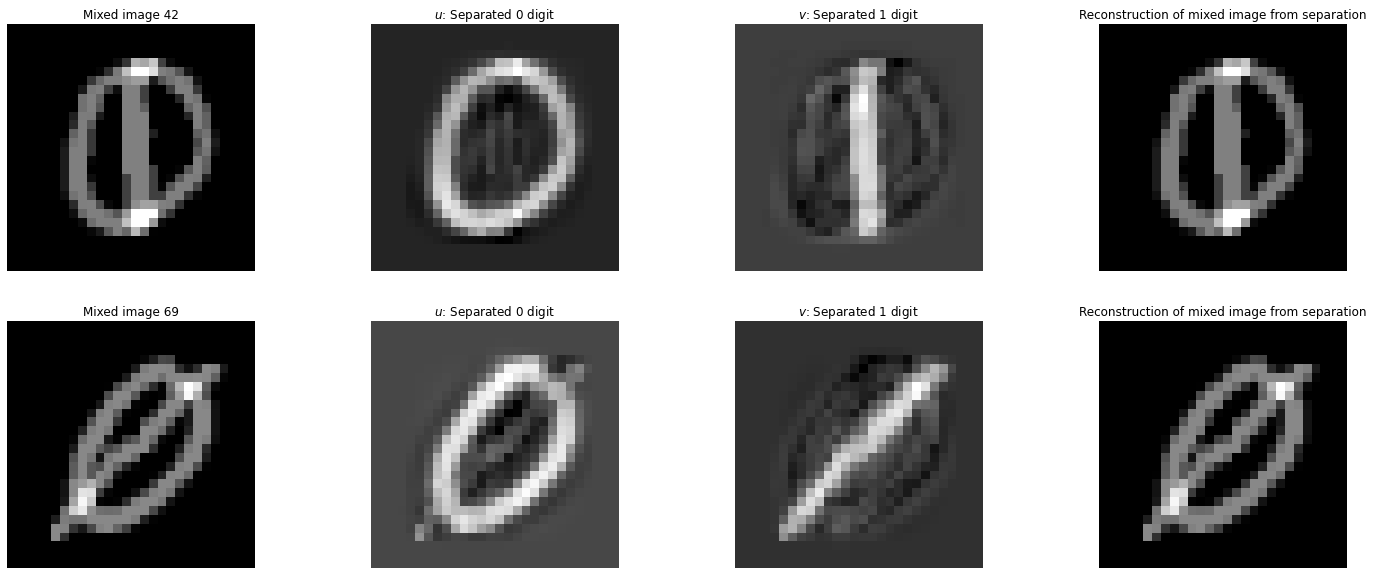

In [ ]:
fig, ax = plt.subplots(2, 4, figsize = (25,10))

ax[0, 0].imshow(m1.reshape((28,28)), cmap = 'gray')
ax[0, 0].set_title('Mixed image 42')
ax[0, 0].axis('off')

ax[0, 1].imshow(u1.reshape((28,28)), cmap = 'gray')
ax[0, 1].set_title(r'$u$: Separated 0 digit')
ax[0, 1].axis('off')

ax[0, 2].imshow(v1.reshape((28,28)), cmap = 'gray')
ax[0, 2].set_title(r'$v$: Separated 1 digit')
ax[0, 2].axis('off')

ax[0, 3].imshow((u1 + v1).reshape((28,28)), cmap = 'gray')
ax[0, 3].set_title(r'Reconstruction of mixed image from separation')
ax[0, 3].axis('off')

ax[1, 0].imshow(m2.reshape((28,28)), cmap = 'gray')
ax[1, 0].set_title('Mixed image 69')
ax[1, 0].axis('off')

ax[1, 1].imshow(u2.reshape((28,28)), cmap = 'gray')
ax[1, 1].set_title(r'$u$: Separated 0 digit')
ax[1, 1].axis('off')

ax[1, 2].imshow(v2.reshape((28,28)), cmap = 'gray')
ax[1, 2].set_title(r'$v$: Separated 1 digit')
ax[1, 2].axis('off')

ax[1, 3].imshow((u2 + v2).reshape((28,28)), cmap = 'gray')
ax[1, 3].set_title(r'Reconstruction of mixed image from separation')
ax[1, 3].axis('off')
plt.show()


We see from the above pictures that our algorithm manages to separate the two digits quite well. However, we observe that the 0 digit is more precisily reconstructed. To further broaden our analysis to a more quantitativ examination, we will use the project material. Firstly, we can consider two different subspaces $Z_0$ and $Z_1$. Representing the linear subspace spanned by the digit 0 and digit 1 basis vectors respectivly. Hence we can define a semi-norm $\| \cdot \|_{B_i}$, as described in the project material, that meassures the distance from a picture to the specific subspace. By doing so we can meassure how far off each of the seperated chennels are to the desired subspace. Idealy, if the separation is done perfectly, we should obtain $\|u \|_{B_0} = \|v \|_{B_1} = 0 \implies u \in Z_0, v \in Z_1$.

The follwing code blocks contains code so this analysis can be preforemed.

In [ ]:
def semi_norm(x, i):
    '''
    Calculating ||X||_{B_i}
    Input:
        x: m x 1 matrix
        i: int, either 0 or 1
    Output:
        res: float
    '''
    n, n = np.shape(W0 @ W0.T)

    if i == 0:
        B = np.identity(n) - W0 @ W0.T
    else:
        B = np.identity(n) - W1 @ W1.T

    res = x.T @ B @ x
    return res


In [ ]:
diff_u = semi_norm(u1, 0)
diff_v = semi_norm(v1, 0)
print(f'Looking at the separation of mixed image 42,\nwe meassure that the separated 0 digit channel is {diff_u} away from Z_0')
print(f'and the separated 1 digit channel is {diff_v} away from Z_1')

Looking at the separation of mixed image 42,
we meassure that the separated 0 digit channel is 3.321113690671328 away from Z_0
and the separated 1 digit channel is 38.008938733739924 away from Z_1


In [ ]:
diff_u = semi_norm(u2, 0)
diff_v = semi_norm(v2, 0)
print(f'Looking at the separation of mixed image 69,\nwe meassure that the separated 0 digit channel is {diff_u} away from Z_0')
print(f'and the separated 1 digit channel is {diff_v} away from Z_1')

Looking at the separation of mixed image 42,
we meassure that the separated 0 digit channel is 4.460747622178084 away from Z_0
and the separated 1 digit channel is 31.83690487493973 away from Z_1


This strengthens our visual assessment. Again we see that the 0 digit is very well reconstructed, while the 1 digit has not been done so well. Regardless of the difference in reconstruction quality we can conclude that the minimal norm apporch can be used in single channel source separation. However, there are some drawbacks to the method. Acquiring the matricies $W_0$ and $W_1$ must be done through machine learning, which requires large sets of learning material to preform well. If the data we want to separate does not have such a corresponding set of learning material, the separation will be very hard to preform. 

On that note we conclude this numerical adventure. 